In [1]:
from fastai.vision import *
import sys

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [2]:
root = Path('../../LIP').resolve()

In [3]:
# R_Shoulder, R_Elbow, L_Shoulder, L_Elbow 
shoulder_elbow = [12, 11, 13 ,14]

class SequentialInstuctor(cs.BaseInstructor):
    n_inst = 16
    
    def __init__(self, instructions, clears=None):
        self.instructions = torch.tensor(instructions).long()
        self.reindex = self.instructions.argsort()
        self.clears = clears if clears else []
        
    def on_batch_begin(self, last_target, train, **kwargs):
        self.i = 0
            
    def next_inst(self, bu_out):
        inst = self.instructions[self.i]
        self.i += 1
        state = {'continue': self.i < len(self.instructions), 'clear': self.i in self.clears}
        
        inst = inst.to(device=bu_out.device).expand(bu_out.shape[0])
        return inst, state
    
    def on_loss_begin(self, last_output, **kwargs):
        last_output = last_output[0], last_output[1][:, self.reindex]
        return {'last_output': last_output}
    
class FilterKeypointsLoss:
    
    def __init__(self, keypoints):
        self.keypoints = sorted(keypoints)
        
    def __call__(self, outputs, targets):
        targets = targets[:, self.keypoints]
        return pose.pose_ce_loss(outputs[1], targets)

loss = FilterKeypointsLoss(shoulder_elbow)
pckh = partial(pose.Pckh, filter_idx=shoulder_elbow)
instructor = SequentialInstuctor(shoulder_elbow, [1])

In [4]:
data = pose.get_data(root, size=128)
data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [8]:
c_out = 1
learner = cs.cs_learner(data, models.resnet18, instructor, td_c=c_out, pretrained=False,
                        loss_func=loss, callback_fns=pckh)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 1.91E-01


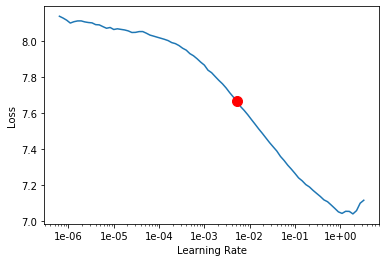

In [9]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [10]:
learner.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,5.739249,5.806286,nan,0.181980,0.108251,nan,nan,nan,nan,0.146232,0.146232,02:12
1,5.263308,5.102575,nan,0.413642,0.228910,nan,nan,nan,nan,0.323016,0.323016,02:11
2,4.712313,4.472737,nan,0.546243,0.341768,nan,nan,nan,nan,0.446106,0.446106,02:13
3,4.409290,4.398188,nan,0.569762,0.377873,nan,nan,nan,nan,0.475673,0.475673,02:13
4,4.189173,4.400776,nan,0.580775,0.408421,nan,nan,nan,nan,0.496334,0.496334,02:13
5,4.043902,4.223675,nan,0.609149,0.441782,nan,nan,nan,nan,0.527020,0.527020,02:12
6,3.886599,4.115727,nan,0.656959,0.419071,nan,nan,nan,nan,0.540270,0.540270,02:13
7,3.801037,3.951958,nan,0.669319,0.426826,nan,nan,nan,nan,0.550108,0.550108,02:14
8,3.676830,4.001796,nan,0.648078,0.473881,nan,nan,nan,nan,0.562852,0.562852,02:14
9,3.641139,3.891413,nan,0.679644,0.413456,nan,nan,nan,nan,0.549068,0.549068,02:14


In [6]:
instructor = SequentialInstuctor(shoulder_elbow, range(4))
learner = cs.cs_learner(data, models.resnet18, instructor, td_c=1, pretrained=False,
                        loss_func=loss, callback_fns=pckh)

In [7]:
learner.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,5.282899,4.808544,nan,0.441247,0.252939,nan,nan,nan,nan,0.349010,0.349010,02:03
1,4.663156,4.641932,nan,0.505520,0.214221,nan,nan,nan,nan,0.362900,0.362900,02:00
2,4.352018,4.483561,nan,0.585981,0.152307,nan,nan,nan,nan,0.373457,0.373457,02:00
3,4.234221,4.402162,nan,0.581556,0.209216,nan,nan,nan,nan,0.399344,0.399344,02:01
4,4.047648,4.206581,nan,0.639628,0.172682,nan,nan,nan,nan,0.411128,0.411128,02:00
5,3.926091,4.171034,nan,0.635056,0.303599,nan,nan,nan,nan,0.472580,0.472580,02:02
6,3.819695,4.073176,nan,0.651170,0.283039,nan,nan,nan,nan,0.470847,0.470847,02:03
7,3.739979,4.058928,nan,0.621952,0.265067,nan,nan,nan,nan,0.447279,0.447279,01:58
8,3.691446,3.998154,nan,0.650124,0.302838,nan,nan,nan,nan,0.480338,0.480338,02:01
9,3.577243,3.878373,nan,0.629376,0.423803,nan,nan,nan,nan,0.529020,0.529020,02:01
